# Build and interact with shapefiles for Southern Oceans fronts and sectors

In [1]:
from os.path import exists
import numpy as np
import pandas as pd
import scipy.io as sio
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
from shapely.geometry import Polygon
from shapely.ops import transform
from pyproj import Transformer
from geopandas import GeoDataFrame
from pandas import DataFrame, Series

In [5]:
kim_orsi_file: str = '../data/in/fronts/ys_fronts.mat'
nsidc_sea_ice_file: str = '../data/in/sea_ice/mean.sep.1979-2021.s'
gray_fronts_file: str = '../data/in/fronts/fronts_Gray.mat'
fronts_shapefile: str = '../data/out/shapefiles/fronts/so_fronts.shp'
zones_shapefile: str = '../data/out/shapefiles/zones/so_zones.shp'
project: Transformer = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), ccrs.SouthPolarStereo(), always_xy=True)

In [ ]:
def create_fronts_zones_shapes():
    """Creates shapefiles for fronts and zones between fronts"""

    # Initialize variables and helper shapes
    shapes: dict = {}
    # Roughly represents the Southern Ocean as a circle along latitude = -29.5
    southern_ocean: Polygon = transform(project.transform, Polygon(
        zip(np.append(np.linspace(start=0, stop=360, num=1000), 0), np.full(1000, -29.5))))

    # Create shapely objects for each front
    stf: Polygon = get_stf()
    shapes['STF'] = stf

    orsi_fronts: list = get_orsi_fronts()
    shapes['SAF'], shapes['PF'], shapes['SACC'] = orsi_fronts

    sie: Polygon = get_sie()
    shapes['SIE'] = sie

    # Create GeoDataFrame with all fronts, export to ESRI shapefile format
    fronts_gdf = GeoDataFrame({'front': shapes.keys(), 'geometry': shapes.values()}, crs=ccrs.SouthPolarStereo())
    fronts_gdf.to_file(fronts_shapefile)

    # Zones are the intersection between the two closest fronts
    zones: list = [southern_ocean - shapes['STF'], shapes['STF'] - shapes['SAF'],
                   shapes['SAF'] - shapes['PF'], shapes['PF'] - shapes['SACC'],
                   shapes['SACC'] - shapes['SIE'], shapes['SIE']]
    names: list = ['STZ', 'SAZ', 'PFZ', 'ASZ', 'SOZ', 'SIZ']

    zones_gdf = GeoDataFrame({'front_zone': names, 'geometry': zones}, crs=ccrs.SouthPolarStereo())
    world: GeoDataFrame = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).to_crs(crs=ccrs.SouthPolarStereo())
    zones_gdf = zones_gdf.overlay(world, how='difference')  # remove land
    zones_gdf.to_file(zones_shapefile)
    print('Success! Shapefiles generated')

In [ ]:
def label_zones(data: DataFrame, lon_col: str, lat_col: str) -> DataFrame:
    """Labels provided data with fronts"""
    assert {lon_col, lat_col}.issubset(
        data.columns), f'"{lon_col}" or "{lat_col}"are not present in the provided DataFrame'
    assert data[lat_col] <= -30, "Provided latitude is not in the Southern Ocean (must be less than -30 degrees)"
    assert exists(
        zones_shapefile), 'missing frontal zones shapefile; try running create_fronts_zones_shapes()'

    data_gdf = GeoDataFrame(data, geometry=gpd.points_from_xy(data[lon_col], data[lat_col]), crs='EPSG:4326')
    data_gdf.to_crs(crs=ccrs.SouthPolarStereo(), inplace=True)

    zones_gdf = gpd.read_file(zones_shapefile).to_crs(ccrs.SouthPolarStereo())
    # Spatially join data points with zones (polygons) to get labelled data
    result = gpd.sjoin(data_gdf, zones_gdf)
    return DataFrame(result.drop(columns='geometry'))


def label_sectors(data: DataFrame, lon_col: str) -> DataFrame:
    """Labels provided data with sectors"""
    assert lon_col in data.columns, f'"{lon_col}" is not present in the provided DataFrame'
    assert data[lon_col].between(-180, 180).all(), f"Data includes longitudes outside of range [-180, 180]"
    # Labels data by sectors (bins) and their latitude range
    # Ross Sea sector overlaps with the start and end of range: [-180, 180] so it is defined with two split ranges
    sectors_series: Series = pd.cut(data[lon_col], bins=[-180, -130, -60, 20, 90, 160, 180],
                                    labels=['Ross', 'BA', 'Weddell', 'Indian', 'WPO', 'Ross'], ordered=False)
    return data.assign(sector=sectors_series)

In [6]:
def get_stf() -> Polygon:
    """Generates Polygon for the SubTropical Front. Data from Gray et al. 2018"""
    gray_mat: dict = sio.loadmat(gray_fronts_file)
    return transform(project.transform, Polygon(zip(gray_mat['lon_stf'][0], gray_mat['lat_stf'][0])))


def get_orsi_fronts() -> list:
    """Generates list of Polygons for the SubAntarctic Front, Polar Front, and Southern ACC Front.
     Data from Kim and Orsi 2014"""
    result: list = []
    orsi_mat: dict = sio.loadmat(kim_orsi_file)
    # fronts = ([[lat1, lon1], [lat2, lon2]], [[lat1, lon1], ...], ...)
    orsi_fronts: tuple = orsi_mat['ys_fronts'].tolist()[0][0]
    # filters out extra data and only keeps the 3 Southern Ocean fronts: (SAF, PF, SACC)
    orsi_fronts = orsi_fronts[:3]
    # points from each front that follow a smooth contour (no holes in the front)
    keep: tuple = ((44, 2633), (0, 2305), (0, 2614))
    for i, orsi_front in enumerate(orsi_fronts):
        # convert np array to df
        front_df = pd.DataFrame(data=orsi_front, columns=['Latitude', 'Longitude'],
                                index=np.arange(len(orsi_front)))
        # remove extra points such as small holes in the front
        front_df = front_df.iloc[keep[i][0]:keep[i][1]]
        # data has points [-180, 360] but [-180, 180] is duplicate of [0, 360]
        front_df = front_df[front_df.Latitude <= 180]
        orsi_shp: Polygon = transform(project.transform,
                                      Polygon(zip(front_df.Latitude, front_df.Longitude)))
        result.append(orsi_shp)
    return result


def get_sie() -> Polygon:
    """Generates Polygon for Sea Ice Concentration.
     Data from NSIDC SMMR and SSM/I-SSMIS v3. Dataset: NSIDC-0192
     Used September mean (1979-2021) for max sea ice extent"""
    ice = np.fromfile(nsidc_sea_ice_file, dtype=np.uint8)
    edge: list = []
    water: bool = True
    # Select grid cells that define edge of sea ice
    for i, conc in enumerate(ice):
        if conc < 100:
            # (previous cell was water and this one is not) OR (vice versa)
            if (water and conc >= 15) or (not water and conc == 0):
                edge.append(i)
            water = conc == 0
    dx = dy = 25000  # Space between grid cells = 25km
    # NSIDC Southern Hemisphere Grid Coordinates (332 rows x 316 cols)
    x, y = np.arange(-3950000, +3950000, +dx), np.arange(+4350000, -3950000, -dy)
    # All points in the grid as 104,912 rows, 2 columns. Note: 104,912 = 332 * 316
    stack_points = np.dstack(np.meshgrid(x, y)).reshape(-1, 2)
    # Only keep points that define the perimeter
    edge_points = stack_points[edge].T
    # Points are in zigzag order because they were inserted as grid cells, not their real order along the perimeter
    # They need to be projected to EPSG: 4326 where they lay flat and then get sorted by the x-axis (longitude)
    # Once sorted, the points will connect to make the desired shape
    flat_points = gpd.points_from_xy(x=edge_points[0], y=edge_points[1], crs=ccrs.SouthPolarStereo()).to_crs(crs='EPSG:4326')
    # All points defining the perimeter as integer pairs
    points = np.vstack((flat_points.x, flat_points.y)).T
    # Sort the points by the x-axis (longitude)
    sorted_points = points[points[:, 0].argsort()]
    # Make Polygon and convert to Southern Hemisphere EPSG
    sie = Polygon(sorted_points)
    return transform(project.transform, sie)

In [7]:
def plot_orsi_fronts():
    """Plots the contents of ys_fronts.mat on a Southern Ocean map"""
    map_proj = ccrs.SouthPolarStereo()
    fig = plt.figure(figsize=[15, 15])  # inches
    ax = plt.subplot(projection=map_proj)
    ax.set_extent([-180, 180, -90, -39.4], ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)

    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=True)

    mat_data: dict = sio.loadmat(kim_orsi_file)
    # mat_data = ([[lat1, lon1], [lat2, lon2]], [[lat1, lon1], ...], ...)
    orsi_fronts: tuple = mat_data['ys_fronts'].tolist()[0][0]
    # filters out extra data and only keeps the 4 Southern Ocean fronts
    orsi_fronts = orsi_fronts[:4]
    colors = ['c', 'b', 'g', 'r']
    for i, orsi_front in enumerate(orsi_fronts):
        front = orsi_front.T
        # data has points [-180, 360] but [-180, 180] is duplicate of [0, 360]
        extra = np.where(front[0] > 180)
        # delete [180, 360]
        lat, lon = np.delete(front[0], extra), np.delete(front[1], extra)
        # remove NaN's
        lat, lon = lat[~np.isnan(lat)], lon[~np.isnan(lon)]
        ax.plot(lat, lon, marker='o', linestyle='', color=colors[i], transform=ccrs.PlateCarree())
    plt.show()


def plot_nsidc_sie():
    """Plots the contents of NSIDC September mean (1979-2021) sea ice extent"""
    map_proj = ccrs.SouthPolarStereo()
    fig = plt.figure(figsize=[15, 15])  # inches
    ax = plt.subplot(projection=map_proj)
    ax.set_extent([-180, 180, -90, -39.4], ccrs.PlateCarree())
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)

    # Credit: Filipe Fernandes (python4oceanographers)
    ice = np.fromfile(nsidc_sea_ice_file, dtype=np.uint8)
    ice = ice.reshape(332, 316)
    ice = ice / 250.
    # mask all land and missing values
    ice = np.ma.masked_greater(ice, 1.0)
    ice = np.ma.masked_less(ice, 0.15)

    ax.add_feature(cartopy.feature.LAND)
    ax.gridlines(draw_labels=True)

    dx = dy = 25000
    x = np.arange(-3950000, +3950000, +dx)
    y = np.arange(+4350000, -3950000, -dy)
    ax.pcolormesh(x, y, ice, cmap=plt.cm.Blues, transform=ccrs.SouthPolarStereo())

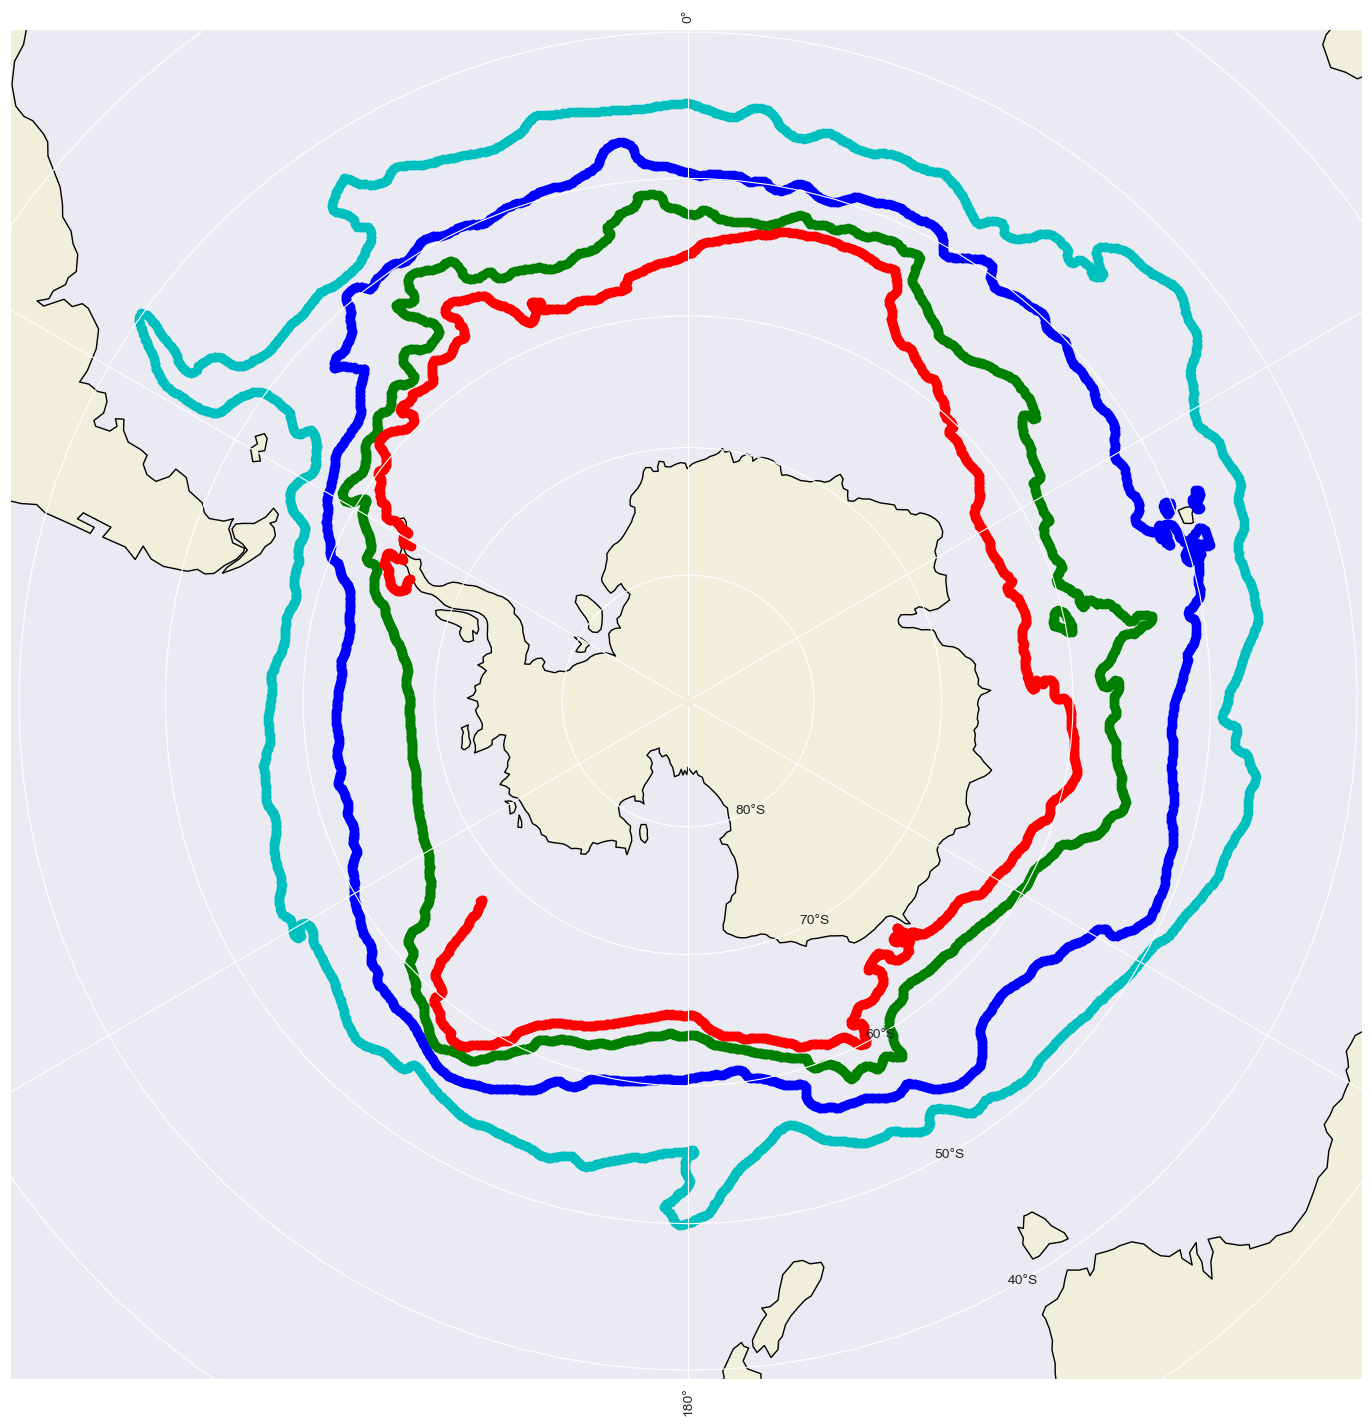

In [8]:
plot_orsi_fronts()

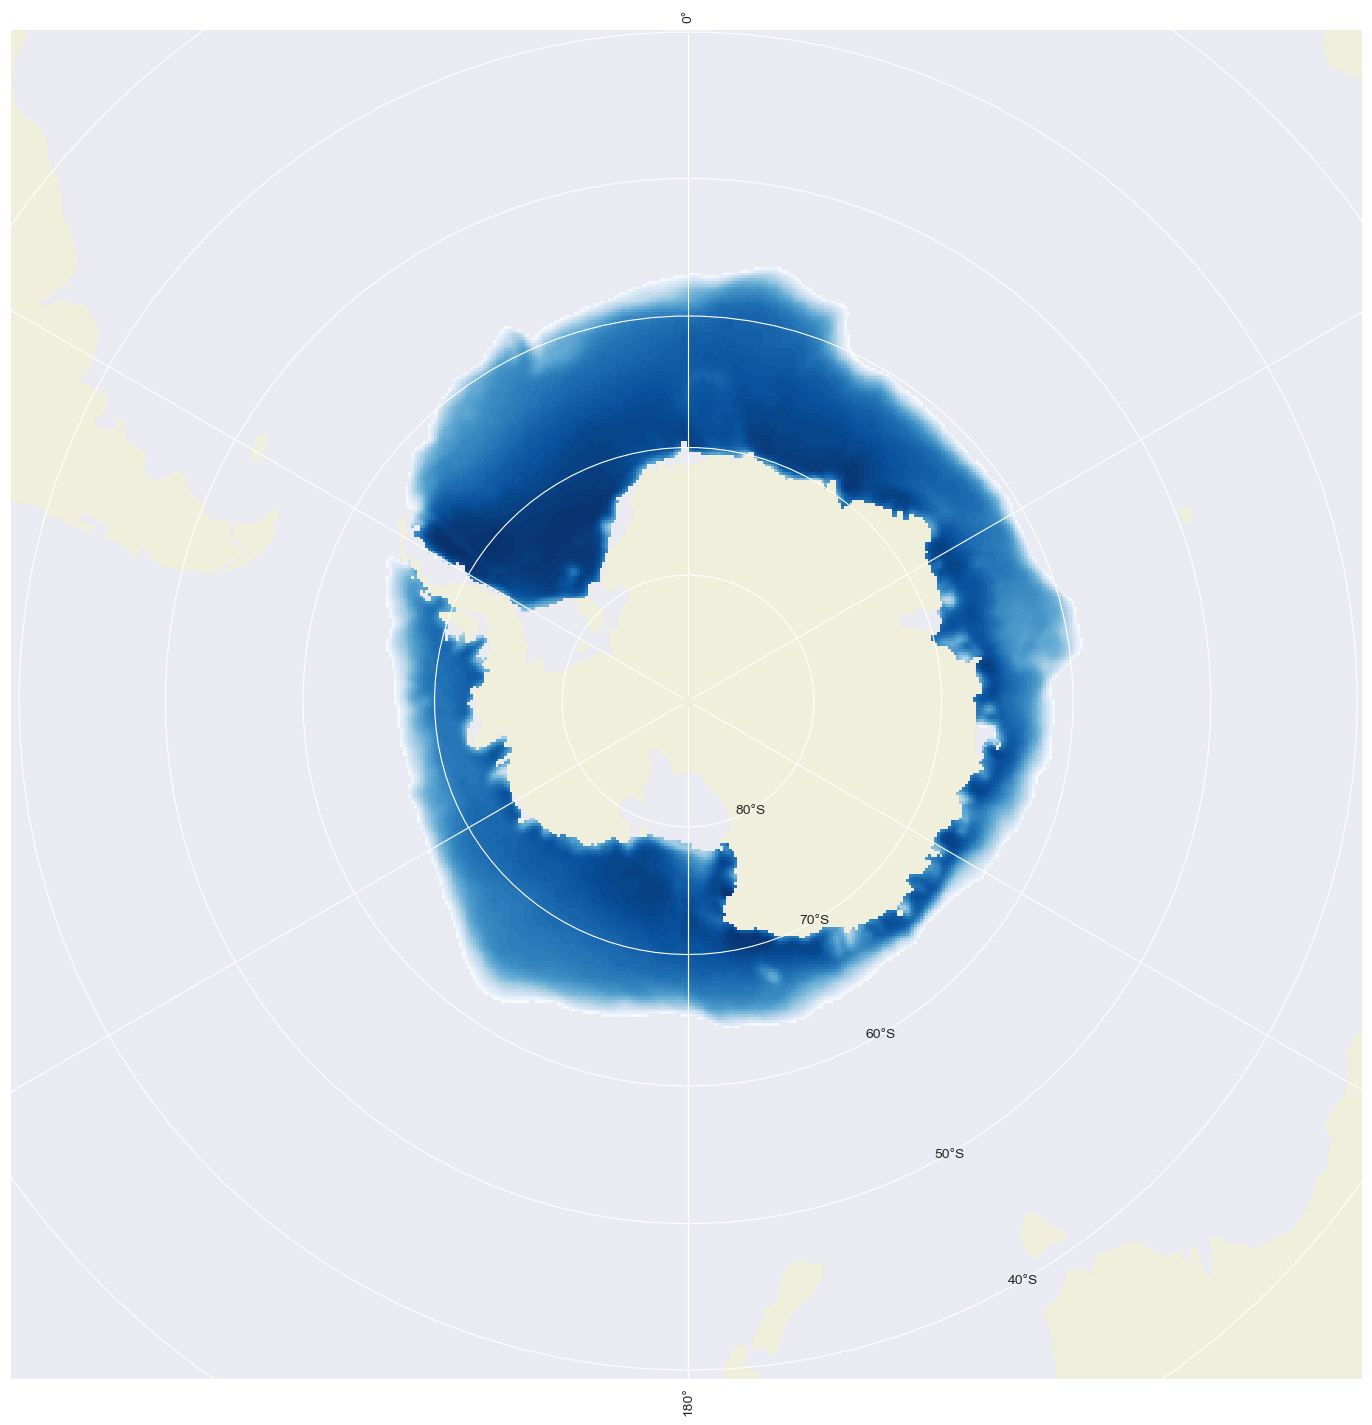

In [9]:
plot_nsidc_sie()